# Predicting housing prices based on parameters

Our project's goal is to create a model that would predict the price of houses in the US.
We got our dataset from [USA Real Estate Dataset](https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset)
created by **Ahmed Shahriar Sakib** in 2024. The dataset contains 12 columns and more than
2.2M records.

The following work will cover most of the processing done by us. From dataset preprocessing
and displaying dataset statistics, to model training.

## Document information
- Authors: Hung Do and Hamza Zakai
- Date: 09/2024
- Class: Machine Learning @ Aalto University

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv("realtor-data.csv")
df.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [57]:
# get column data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB


In [58]:
# number of missing values (NaN) for each column
df.isna().sum()

brokered_by         4533
status                 0
price               1541
bed               481317
bath              511771
acre_lot          325589
street             10866
city                1407
state                  8
zip_code             299
house_size        568484
prev_sold_date    734297
dtype: int64

## Dataset preprocessing

Before we start working with the dataset, we need to do the analysis and edit the dataset
to the desired format. The dataset contains lots of missing values (land size), some columns
were loaded with a wrong dataset (`zip_code` is not a `float64` but a string) and more. 

In this section we will focus on two things:
1) Either repair missing values or remove items if not possible,
2) Change the column data types to reduce the size of the DataFrame.

#### Repair or remove records with missing values

In [59]:
# drop rows with missing values
df = df.dropna(subset=['price', 'state', 'zip_code', 'house_size', 'acre_lot'])
df = df.loc[(df['bed'].notna()) & (df['bath'].notna())].reset_index(drop=True)
df = df.drop(['city'], axis=1) # dropped as its tied to the zip code

# fix some data
df['brokered_by'] = df['brokered_by'].fillna(-1)
df['street'] = df['street'].fillna(-1)
df['prev_sold_date'] = df['prev_sold_date'].notna()
df['zip_code'] = df['zip_code'].astype(int).astype(str)
df['zip_code'] = df['zip_code'].str.pad(5, 'left', '0')
df

,brokered_by,status,price,bed,bath,acre_lot,street,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Puerto Rico,00601,920.0,False
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Puerto Rico,00601,1527.0,False
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Puerto Rico,00795,748.0,False
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Puerto Rico,00731,1800.0,False
4,103378.0,for_sale,179000.0,4.0,3.0,0.46,1850806.0,Puerto Rico,00612,2520.0,False
...,...,...,...,...,...,...,...,...,...,...,...
1360622,23009.0,sold,359900.0,4.0,2.0,0.33,353094.0,Washington,99354,3600.0,True
1360623,18208.0,sold,350000.0,3.0,2.0,0.10,1062149.0,Washington,99354,1616.0,True
1360624,76856.0,sold,440000.0,6.0,3.0,0.50,405677.0,Washington,99354,3200.0,True
1360625,53618.0,sold,179900.0,2.0,1.0,0.09,761379.0,Washington,99354,933.0,True


#### Optimize data types

In [60]:
df['brokered_by'] = df['brokered_by'].astype(int)
df['status'] = df['status'].astype('category')
df['bed'] = df['bed'].astype(int)
df['bath'] = df['bath'].astype(int)
df['street'] = df['street'].astype(int)
df['state'] = df['state'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1360627 entries, 0 to 1360626
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype   
---  ------          --------------    -----   
 0   brokered_by     1360627 non-null  int64   
 1   status          1360627 non-null  category
 2   price           1360627 non-null  float64 
 3   bed             1360627 non-null  int64   
 4   bath            1360627 non-null  int64   
 5   acre_lot        1360627 non-null  float64 
 6   street          1360627 non-null  int64   
 7   state           1360627 non-null  category
 8   zip_code        1360627 non-null  object  
 9   house_size      1360627 non-null  float64 
 10  prev_sold_date  1360627 non-null  bool    
dtypes: bool(1), category(2), float64(3), int64(4), object(1)
memory usage: 86.9+ MB


We manage to reduce the size of the dataset from **203.8MB+** to **86.9MB**.

## Statistics

Now we perform some statistical analysis on the given dataset. In this section we will look
at the distribution of some features. In the second part of the section we will remove outliers
for better model training.

In [61]:
df[list(set(df.columns) - {'brokered_by', 'street'})].describe()

,price,bed,acre_lot,bath,house_size
count,1.360627e+06,1.360627e+06,1.360627e+06,1.360627e+06,1.360627e+06
mean,5.734360e+05,3.386161e+00,1.274836e+01,2.541960e+00,2.120834e+03
std,1.226337e+06,1.428047e+00,7.996613e+02,1.363278e+00,4.175516e+03
min,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+02
25%,2.390000e+05,3.000000e+00,1.400000e-01,2.000000e+00,1.360000e+03
50%,3.790000e+05,3.000000e+00,2.100000e-01,2.000000e+00,1.812000e+03
75%,6.000000e+05,4.000000e+00,4.600000e-01,3.000000e+00,2.478000e+03
max,5.150000e+08,4.440000e+02,1.000000e+05,2.220000e+02,1.560780e+06


In [62]:
df_new = df.copy(deep=True)

In [88]:
df_new.sort_values('price', ascending=False).head(10)[['price', 'state', 'zip_code', 'bath', 'bed']]
# df_new.sort_values('bath')


,price,state,zip_code,bath,bed
673441,515000000.0,California,92119,2,2
51010,169000000.0,New York,10022,9,6
651116,165000000.0,California,90024,27,14
684434,160000000.0,California,93013,21,10
236323,150000000.0,Florida,33129,21,12
243971,115000000.0,Florida,33480,13,7
684446,109000000.0,California,93013,4,3
243123,106000000.0,Florida,33462,13,9
24839,100000000.0,Connecticut,06820,10,10
684836,100000000.0,California,93023,12,7


### Broker/agency statistics

In [64]:
# number of brokers/agencies
print("Number of brokers: ", len(df['brokered_by'].unique()))

# top brokers
print("Top brokers: ")
print(
    df.groupby('brokered_by') \
        .count() \
        .sort_values('price', ascending=False)['price'] \
        .head(10) \
        .to_string(header=False)
)

Number of brokers:  91327
Top brokers: 
22611     29790
16829     18002
53016     15341
30807      5725
33714      4806
23592      4624
84534      4243
79221      4237
109978     4208
70677      3778


### Prices

When analyzing the prices of properties we can see that there are plenty of outliers.
The range is so huge that we cannot see the majority of the houses in the graph. Some properties
cost more than 500 million USD. We will have to reduce the dataset later by removing some outliers
for better model training.

In [65]:
import matplotlib.pyplot as plt

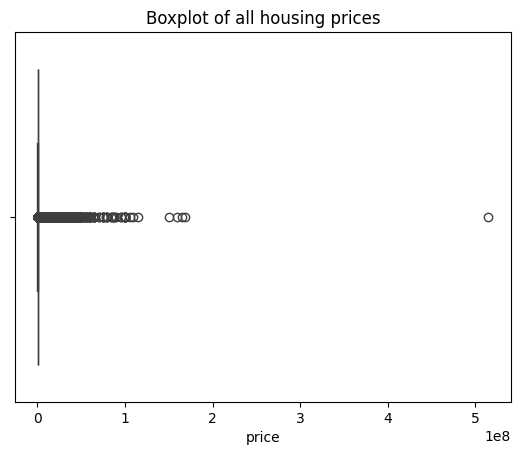

In [66]:
fig, ax = plt.subplots(1, 1)
g = sns.boxplot(df.loc[df['price'] < 1e10], x='price', ax=ax)
_ = g.set(title="Boxplot of all housing prices")

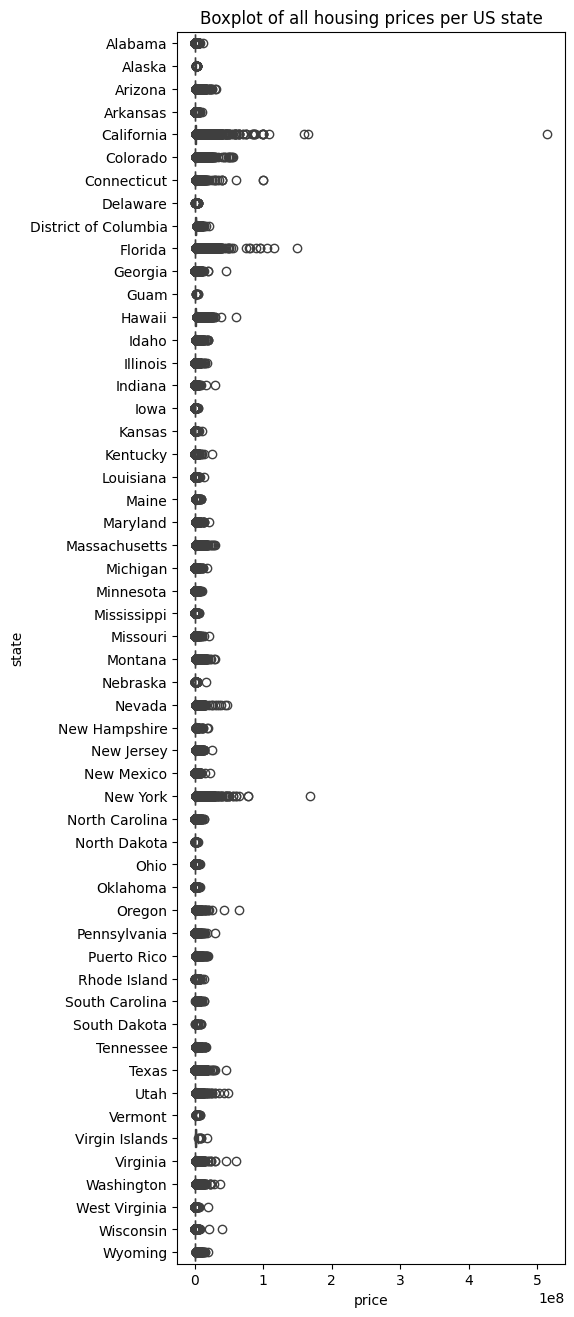

In [67]:
# here we can see the boxplot of the housing prices in each US state
fig, ax = plt.subplots(1, 1, figsize=(5, 16))
g = sns.boxplot(df, x='price', y='state')
_ = g.set(title="Boxplot of all housing prices per US state")

### Beds and Baths

When analyzing the number of bathrooms and bedroom we can see that there are plenty of outliers.
The graph shows us that most of the houses at most 10 bedrooms/bathrooms, but there are houses that
have more than 400 bedrooms and 200 bathrooms. We will have to minimize the number of outliers in
this dataset for optimal training.

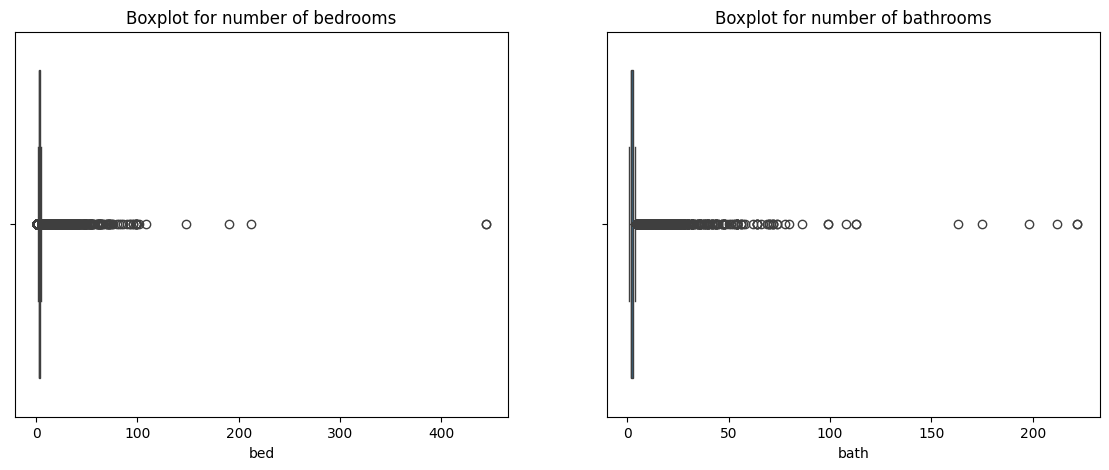

In [68]:
f, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title("Boxplot for number of bedrooms")
ax[1].set_title("Boxplot for number of bathrooms")
sns.boxplot(df, x='bed', ax=ax[0])
_ = sns.boxplot(df, x='bath', ax=ax[1])

## Outliers reduction

In [69]:
from sklearn.ensemble import IsolationForest

df['status'] = df['status'].cat.rename_categories([0, 1])
df['state'] = df['state'].cat.rename_categories(list(range(len(df['state'].unique()))))
df = df.loc[(df['price'] > 1e4) & (df['price'] < 3e6) & (df['acre_lot'] > 0) & (df['house_size'] > 0) & (df['bed'] <= 15) & (df['bath'] <= 15)]

iso = IsolationForest(contamination=0.1)
outliers = iso.fit_predict(df[list(set(df.columns) - {'brokered_by', 'street', 'zip_code'})])
df['ISO'] = outliers
df


/tmp/ipykernel_15276/376921631.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ISO'] = outliers


,brokered_by,status,price,bed,bath,acre_lot,street,state,zip_code,house_size,prev_sold_date,ISO
0,103378,0,105000.0,3,2,0.12,1962661,40,00601,920.0,False,1
1,52707,0,80000.0,4,2,0.08,1902874,40,00601,1527.0,False,1
2,103379,0,67000.0,2,1,0.15,1404990,40,00795,748.0,False,-1
3,31239,0,145000.0,4,2,0.10,1947675,40,00731,1800.0,False,1
4,103378,0,179000.0,4,3,0.46,1850806,40,00612,2520.0,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1360622,23009,1,359900.0,4,2,0.33,353094,50,99354,3600.0,True,1
1360623,18208,1,350000.0,3,2,0.10,1062149,50,99354,1616.0,True,1
1360624,76856,1,440000.0,6,3,0.50,405677,50,99354,3200.0,True,1
1360625,53618,1,179900.0,2,1,0.09,761379,50,99354,933.0,True,1


In [70]:
df = df.loc[df['ISO'] == 1]
df.describe()

,brokered_by,price,bed,bath,acre_lot,street,house_size,ISO
count,1.204458e+06,1.204458e+06,1.204458e+06,1.204458e+06,1.204458e+06,1.204458e+06,1.204458e+06,1204458.0
mean,5.358663e+04,4.213378e+05,3.248699e+00,2.348582e+00,5.408202e-01,9.273167e+05,1.877348e+03,1.0
std,3.039664e+04,2.880859e+05,8.460782e-01,8.413424e-01,1.232267e+00,5.341877e+05,7.281798e+02,0.0
min,-1.000000e+00,1.040000e+04,1.000000e+00,1.000000e+00,1.000000e-02,-1.000000e+00,1.000000e+02,1.0
25%,2.541200e+04,2.290000e+05,3.000000e+00,2.000000e+00,1.400000e-01,4.621835e+05,1.341000e+03,1.0
50%,5.301600e+04,3.500000e+05,3.000000e+00,2.000000e+00,2.000000e-01,9.303535e+05,1.748000e+03,1.0
75%,7.922100e+04,5.350000e+05,4.000000e+00,3.000000e+00,3.700000e-01,1.389144e+06,2.290000e+03,1.0
max,1.101420e+05,2.999999e+06,1.200000e+01,1.200000e+01,2.332000e+01,2.001321e+06,1.999800e+04,1.0


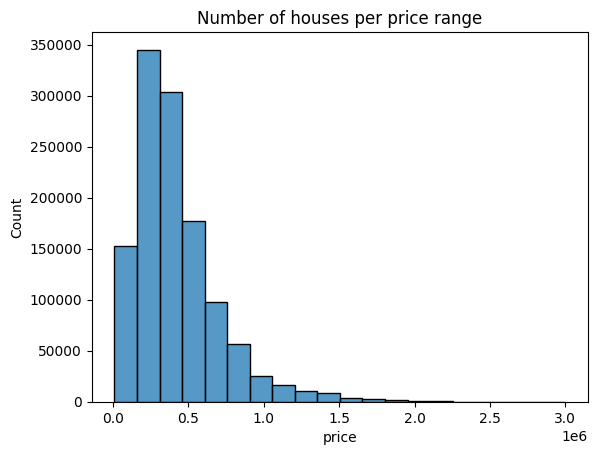

In [71]:
g = sns.histplot(df, x='price', bins=20)
_ = g.set_title("Number of houses per price range")

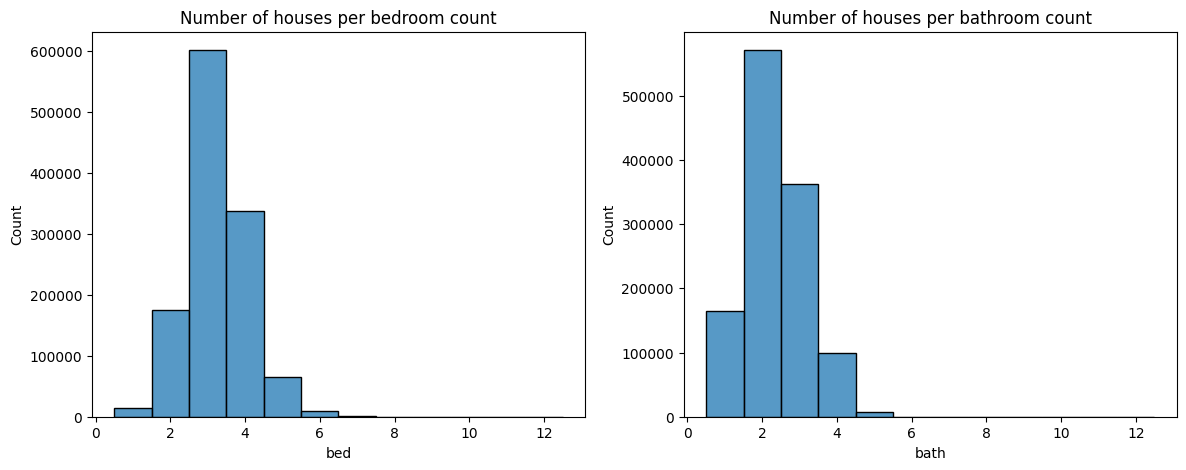

In [72]:
f, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title("Number of houses per bedroom count")
ax[1].set_title("Number of houses per bathroom count")
sns.histplot(df, x='bed', ax=ax[0], discrete=True)
_ = sns.histplot(df, x='bath', ax=ax[1], discrete=True)

## Create price categories

In [73]:
bins = [0] + [100000 + i*50000 for i in range(19)] + [df['price'].max()]
labels = [f"{i//1000}K" for i in bins[:-1]]
df['bins'] = pd.cut(df['price'], bins=bins, labels=labels)
df[['price', 'bins']].sort_values('price')

/tmp/ipykernel_15276/3017641668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.cut(df['price'], bins=bins, labels=labels)


,price,bins
1019697,10400.0,0K
443357,10500.0,0K
1008547,10500.0,0K
288063,10500.0,0K
81737,10500.0,0K
...,...,...
649988,2995000.0,1000K
240184,2995000.0,1000K
266500,2995000.0,1000K
659560,2995000.0,1000K


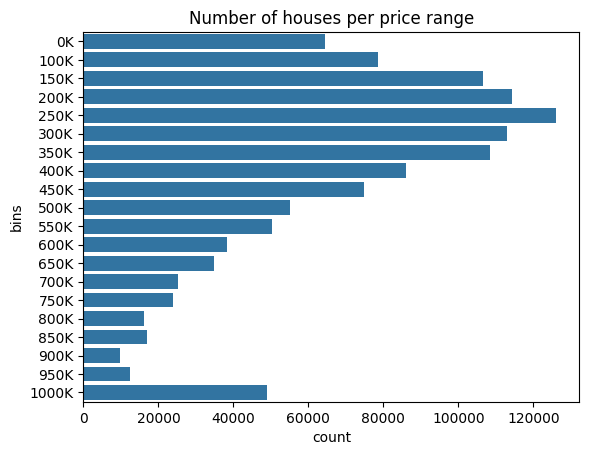

In [74]:
df_bins = df.groupby('bins', observed=False).count().unstack()['price']
df_bins = df_bins.reset_index().rename(columns={0: "count"})
g = sns.barplot(df_bins, x='count', y='bins')
_ = g.set_title("Number of houses per price range")

In [89]:
df = df.drop('ISO', axis=1)
df

,brokered_by,status,price,bed,bath,acre_lot,street,state,zip_code,house_size,prev_sold_date,ISO,bins
0,103378,0,105000.0,3,2,0.12,1962661,40,00601,920.0,False,1,100K
1,52707,0,80000.0,4,2,0.08,1902874,40,00601,1527.0,False,1,0K
3,31239,0,145000.0,4,2,0.10,1947675,40,00731,1800.0,False,1,100K
4,103378,0,179000.0,4,3,0.46,1850806,40,00612,2520.0,False,1,150K
5,1205,0,50000.0,3,1,0.20,1298094,40,00639,2040.0,False,1,0K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360622,23009,1,359900.0,4,2,0.33,353094,50,99354,3600.0,True,1,350K
1360623,18208,1,350000.0,3,2,0.10,1062149,50,99354,1616.0,True,1,300K
1360624,76856,1,440000.0,6,3,0.50,405677,50,99354,3200.0,True,1,400K
1360625,53618,1,179900.0,2,1,0.09,761379,50,99354,933.0,True,1,150K
